# EDA<a id='EDA'></a>

## 1 Contents<a id='1_Contents'></a>
* [EDA](#EDA)
  * [1 Contents](#1_Contents)
  * [2 Introduction](#2_Introduction)
  * [3 Imports](#3_Imports)
  * [4 Load the data](#4_Load_the_data)
  * [5 Dates and positions](#5_Dates_and_positions)
  * [6 Stats functions](#6_Stats_functions)
    * [6.1 Player stats](#6.1_Player_stats)
    * [6.2 Fixing shift times](#6.2_Fixing_shift_times)
    * [6.3 Another player stat](#6.3_Another_player_stat)
    * [6.4 Team stats](#6.4_Team_stats)
  * [7 Creating dataframes](#7_Creating_dataframes)
  * [8 Visualizing trends](#8_Visualizing_trends)
  * [9 Save the data](#9_Save_the_data)
  * [10 Summary](#10_Summary)

## 2 Introduction<a id='2_Introduction'></a>

Most of this notebook actually consists of further data wrangling; the main goal is to create new dataframes which contain the relevant statistics we would like to use in feature creation. For example, in order to use "shot attempts" as a feature in our model, we create a function which, given a time window, outputs a pandas series giving each player's number of shot attempts during that time window. We use these functions to create dataframes for these statistics for seasons from 2010 to 2020, breaking each season roughly into thirds. We visualize these stats (across the whole league) over the decade, seeing that attempts, shots-on-goal, and goals are indeed correlated, justifying our interest in attempts as a useful feature.

## 3 Imports<a id='3_Imports'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from library.sb_utils import save_file

## 4 Load the data<a id='4_Load_the_data'></a>

In [2]:
datapath = '../data/interim/'

names = ['game', 'team_info', 'game_goals', 'game_plays', 'game_shifts', 'player_info', 'game_scratches',
              'game_teams_stats', 'game_skater_stats', 'game_plays_players']

for name in names:
    globals()['df_' + name] = pd.read_csv(datapath + name + '_new.csv')

In [3]:
#this code does nothing except tell VSCode that these variables are indeed defined...

df_game = df_game
df_game_goals = df_game_goals
df_game_plays = df_game_plays
df_game_plays_players = df_game_plays_players
df_game_scratches = df_game_scratches
df_game_shifts = df_game_shifts
df_game_skater_stats = df_game_skater_stats
df_game_teams_stats = df_game_teams_stats
df_player_info = df_player_info
df_team_info = df_team_info

## 5 Dates and positions<a id='5_Dates_and_positions'></a>

In [4]:
df_player_info.head(2)

,player_id,firstName,lastName,primaryPosition,birthDate,height_cm,weight
0,8466148,Marian,Hossa,RW,1979-01-12 00:00:00,185.42,207.0
1,8465058,Michal,Rozsival,D,1978-09-03 01:00:00,185.42,210.0


We only need the date, not the time in the birthDate column.

In [5]:
df_player_info['birthDate'] = pd.to_datetime(df_player_info['birthDate']).dt.date

In [6]:
df_player_info.head(2)

,player_id,firstName,lastName,primaryPosition,birthDate,height_cm,weight
0,8466148,Marian,Hossa,RW,1979-01-12,185.42,207.0
1,8465058,Michal,Rozsival,D,1978-09-03,185.42,210.0


In [7]:
df_player_info['primaryPosition'].unique()

array(['RW', 'D', 'C', 'G', 'LW'], dtype=object)

Let's drop the goalies from our data.

In [8]:
df_player_info = df_player_info[~(df_player_info['primaryPosition'] == 'G')]

In [9]:
df_player_info['primaryPosition'].unique()

array(['RW', 'D', 'C', 'LW'], dtype=object)

And now let's simplify our model by making the new categorical feature isForward which we will use going forward instead of primaryPosition.

In [10]:
df_player_info['isForward'] = df_player_info['primaryPosition'].isin(['LW', 'RW', 'C'])

Let's now make a simplified version of this dataframe as our starting point for building our training and test data.

In [11]:
my_player_info = df_player_info[['player_id', 'isForward', 'birthDate', 'height_cm', 'weight']]

In [12]:
my_player_info.head()

,player_id,isForward,birthDate,height_cm,weight
0,8466148,True,1979-01-12,185.42,207.0
1,8465058,False,1978-09-03,185.42,210.0
2,8476906,False,1993-04-20,180.34,180.0
3,8466285,False,1979-05-23,177.80,192.0
4,8470607,False,1985-04-20,190.50,220.0


In [13]:
df_game.head(2)

,game_id,season,date_time_GMT,home_team_id,away_team_id,home_goals,away_goals,outcome
0,2016020045,20162017,2016-10-19T00:30:00Z,16,4,7,4,home win REG
1,2017020812,20172018,2018-02-07T00:00:00Z,7,24,3,4,away win OT


We only need to know the date, not the time of day, so let's simplify the date column.

In [14]:
df_game['date'] = pd.to_datetime(df_game['date_time_GMT']).dt.date

In [15]:
df_game = df_game.drop('date_time_GMT', axis=1)

In [16]:
df_game.head(2)

,game_id,season,home_team_id,away_team_id,home_goals,away_goals,outcome,date
0,2016020045,20162017,16,4,7,4,home win REG,2016-10-19
1,2017020812,20172018,7,24,3,4,away win OT,2018-02-07


## 6 Stats functions<a id='6_Stats_functions'></a>

Each of the functions below will work within a given time period, so will make use of the following function which simply selects the games in the given time period.

In [17]:
def find_games_in_time_period(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    return df_game[(df_game['date'] >= start) & (df_game['date'] < end)]        # note: inclusive of start, not of end

### 6.1 Player stats<a id='6.1_Player_stats'></a>

Each of the following functions will output a pandas series, indexed by player_id, providing the total count in the given time period for the stat in question.

In [18]:
def attempted_shots(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """An attempted shot is any goal, shot-on-goal, missed shot, or blocked shot. This function outputs a pandas series, indexed by player_id,
    which gives the total number of attempted shots by each player in the given time period."""
    games = find_games_in_time_period(start, end)
    games_subset = df_game_plays_players['game_id'].isin(games['game_id'])
    shooter_subset = df_game_plays_players['playerType'].isin(['Shooter', 'Scorer'])
    attempted_shots = df_game_plays_players[games_subset & shooter_subset]
    return attempted_shots.groupby('player_id').size()

In [19]:
def shots_on_goal(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """In the data set, a 'shot' is a shot on net which was not a goal, so we want to include shots and goals. This function outputs a pandas series,
    indexed by player_id, which gives the total number of shots on goal by each player in the given time period."""
    games = find_games_in_time_period(start, end)
    games_subset = df_game_plays_players['game_id'].isin(games['game_id'])
    sog_ids = df_game_plays[df_game_plays['event'].isin(['Goal', 'Shot'])]['play_id']
    sog_subset = df_game_plays_players['play_id'].isin(sog_ids)
    shooter_subset = df_game_plays_players['playerType'].isin(['Shooter', 'Scorer'])
    shots = df_game_plays_players[games_subset & sog_subset & shooter_subset]
    return shots.groupby('player_id').size()

In [20]:
def goals(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """This function outputs a pandas series, indexed by player_id, which gives the total number of goals by each player in the given time period."""
    games = find_games_in_time_period(start, end)
    games_subset = df_game_plays_players['game_id'].isin(games['game_id'])
    scorer_subset = (df_game_plays_players['playerType'] == 'Scorer')
    goals = df_game_plays_players[games_subset & scorer_subset]
    return goals.groupby('player_id').size()

In [21]:
def assists(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """This function outputs a pandas series, indexed by player_id, which gives the total number of assists by each player in the given time period."""
    games = find_games_in_time_period(start, end)
    games_subset = df_game_plays_players['game_id'].isin(games['game_id'])
    assister_subset = (df_game_plays_players['playerType'] == 'Assist')
    assists = df_game_plays_players[games_subset & assister_subset]
    return assists.groupby('player_id').size()

In [22]:
def games(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """This function outputs a pandas series, indexed by player_id, which gives the total number of games played by each player in the given time period."""
    games = find_games_in_time_period(start, end)['game_id']
    game_skaters = df_game_skater_stats[df_game_skater_stats['game_id'].isin(games)]
    return game_skaters.groupby('player_id').size()

In [23]:
def toi(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """This function outputs a pandas series, indexed by player_id, which gives the total time-on-ice (in sec) by each player in the given time period."""
    games = find_games_in_time_period(start, end)['game_id']
    game_skaters = df_game_skater_stats[df_game_skater_stats['game_id'].isin(games)]
    return game_skaters.groupby('player_id')['timeOnIce'].sum()

In [24]:
def pp_toi(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """This function outputs a pandas series, indexed by player_id, which gives the total power-play time-on-ice (in sec) by each player
    in the given time period."""
    games = find_games_in_time_period(start, end)['game_id']
    game_skaters = df_game_skater_stats[df_game_skater_stats['game_id'].isin(games)]
    return game_skaters.groupby('player_id')['powerPlayTimeOnIce'].sum()

### 6.2 Fixing shift times<a id='6.2_Fixing_shift_times'></a>

There is an inconsistency between shift start/end times in df_game_shifts and the play times in df_game_plays.

In [25]:
df_game_shifts[df_game_shifts['period'] == 3]['shift_start'].describe()

count    3.290944e+06
mean     2.973821e+03
std      3.534514e+02
min      2.400000e+03
25%      2.665000e+03
50%      2.973000e+03
75%      3.281000e+03
max      3.600000e+03
Name: shift_start, dtype: float64

In [26]:
df_game_plays['periodTime'].max()

1200

The shift times use the absolute time in the game, but the plays use the time in the period. Let's convert the shifts times to period time.

In [27]:
df_game_shifts['shift_start'] = df_game_shifts['shift_start'] - (1200 * (df_game_shifts['period'] - 1))
df_game_shifts['shift_end'] = df_game_shifts['shift_end'] - (1200 * (df_game_shifts['period'] - 1))

In [28]:
df_game_shifts['shift_start'].describe()

count    9.900276e+06
mean     5.681265e+02
std      3.567704e+02
min      0.000000e+00
25%      2.540000e+02
50%      5.640000e+02
75%      8.780000e+02
max      1.200000e+03
Name: shift_start, dtype: float64

### 6.3 Another player stat<a id='6.3_Another_player_stat'></a>

In [29]:
def onice_attempts(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """An attempted shot is any goal, shot-on-goal, missed shot, or blocked shot. This function outputs a pandas series, indexed by player_id,
    which gives the total number of attempted shots by each player's team when that player is on the ice in the given time period."""
    time_stretch = find_games_in_time_period(start, end)
    df_time = df_game_plays[df_game_plays['game_id'].isin(time_stretch['game_id'])]

    join_shift_team_id = df_game_shifts.merge(df_game_skater_stats[['game_id', 'player_id', 'team_id']], how='left', on=['game_id', 'player_id'])

    # We will eventually combine all of the following four event types as 'attempted shots,' but we want to deal with them separately for now
    events = ['Goal', 'Shot', 'Blocked Shot', 'Missed Shot']

    series = []

    # The join in this loop is very large, which is why we are not doing it for all four event types at once
    for event in events:
        df = df_time[df_time['event'] == event]
        join = df.merge(join_shift_team_id, how='inner', left_on=['game_id', 'period', 'team_id_for'], right_on=['game_id', 'period', 'team_id'])
        onice = join[(join['periodTime'] >= join['shift_start']) & (join['periodTime'] <= join['shift_end'])]
        series.append(onice.groupby('player_id').size())

    # We have a list of series for each event type which we sum together
    all_onice = series[0]
    for i in range(1,4):
        # we use .add with fill_value=0 in order to add zero for any missing values (if a player
        # was not on the ice for a certain event type during a period)
        all_onice = all_onice.add(series[i], fill_value=0)
    return all_onice.astype(int)

### 6.4 Team stats<a id='6.4_Team_stats'></a>

In [30]:
def goals_by_team(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """This function outputs a pandas series, indexed by team_id, which gives the total number of goals scored by each team in the given time period."""
    games = find_games_in_time_period(start, end)
    home_goals = games.groupby('home_team_id')['home_goals'].sum()
    away_goals = games.groupby('away_team_id')['away_goals'].sum()
    return home_goals + away_goals

In [31]:
def attempts_by_team(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """This function outputs a pandas series, indexed by team_id, which gives the total number of shot attempts by each team in the given time period."""
    games = find_games_in_time_period(start, end)
    events = ['Goal', 'Shot', 'Blocked Shot', 'Missed Shot']
    df_attempts = df_game_plays[(df_game_plays['game_id'].isin(games['game_id'])) & (df_game_plays['event'].isin(events))]
    return df_attempts.groupby('team_id_for').size()

In [32]:
def games_by_team(start=dt.date(1000, 1, 1), end=dt.date(3000, 1, 1)):
    """This function outputs a pandas series, indexed by team_id, which gives the total number of games played by each team in the given time period."""
    games = find_games_in_time_period(start, end)
    home_games = games.groupby('home_team_id').size()
    away_games = games.groupby('away_team_id').size()
    return home_games + away_games

## 7 Creating dataframes<a id='7_Creating_dataframes'></a>

In [33]:
seasons = list(df_game['season'].unique())

seasons.sort()

Before the 2010-2011 season, there was not the same level of shot-attempt tracking, so we are only going to include the data starting in 2010.

In [34]:
seasons = seasons[9:]

In [35]:
def divide_season(season):
    games = df_game[df_game['season'] == season].sort_values('date')
    start_of_season = games.iloc[0,7]   # 7 is in the index of the date column
    first_third = games.iloc[410,7]     # The number 410 here was chosen because it roughly divides most seasons into thirds.
    ls = [start_of_season, first_third]
    if len(games) > 820:                # The 2012-2013 season was shortened due to a lockout, so there were less than 820 games. For all other season,
                                        # we add one more division (about 2/3 of the way through the season) to our list ls.
        second_third = games.iloc[820,7]
        ls.append(second_third)
    return ls

In [36]:
divisions = []

for season in seasons:
    divisions += divide_season(season)

divisions[-1] = dt.date(3000,1,1)
divisions[-2] = dt.date(2019,12,23)     # manually adjusting 2019-2020 season to have just one division at roughly the mid-point

windows = list(zip(divisions, divisions[1:]))

The 2019-2020 season was somewhat shortened due to COVID-19, so rather than divide it into three shorter windows, we have opted to make it two longer windows. We will reserve these two windows for testing.

We now create dataframes which use the functions above for each window.

In [37]:
def make_player_df(i, window):
    start = window[0]
    end = window[1]
    df = df_player_info[['player_id']].set_index('player_id')
    functions = [attempted_shots, shots_on_goal, goals, assists, games, toi, pp_toi, onice_attempts]
    for f in functions:
        df[f.__name__ + '_' + str(i)] = f(start, end)
    return df

In [38]:
def make_team_df(i, window):
    start = window[0]
    end = window[1]
    df = df_team_info[['team_id']].set_index('team_id')
    functions = [goals_by_team, attempts_by_team, games_by_team]
    for f in functions:
        df[f.__name__ + '_' + str(i)] = f(start, end)
    return df

In [39]:
player_dfs = [make_player_df(i, window) for i, window in enumerate(windows)]
player_df = pd.concat(player_dfs, axis=1)

team_dfs = [make_team_df(i, window) for i, window in enumerate(windows)]
team_df = pd.concat(team_dfs, axis=1)

In [40]:
player_df.head()

,attempted_shots_0,shots_on_goal_0,goals_0,assists_0,games_0,toi_0,pp_toi_0,onice_attempts_0,attempted_shots_1,shots_on_goal_1,...,pp_toi_26,onice_attempts_26,attempted_shots_27,shots_on_goal_27,goals_27,assists_27,games_27,toi_27,pp_toi_27,onice_attempts_27
player_id,,,,,,,,,,,,,,,,,,,,,
8466148,89.0,59.0,8.0,7.0,21.0,25096.0,3337.0,423.0,88.0,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8465058,55.0,16.0,2.0,7.0,20.0,27325.0,4313.0,475.0,37.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8476906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5157.0,636.0,40.0,20.0,NaN,3.0,10.0,10911.0,1597.0,189.0
8466285,48.0,22.0,1.0,7.0,17.0,22531.0,2380.0,356.0,78.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8470607,109.0,47.0,2.0,14.0,30.0,44955.0,4695.0,751.0,64.0,29.0,...,1378.0,573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
team_df.head()

,goals_by_team_0,attempts_by_team_0,games_by_team_0,goals_by_team_1,attempts_by_team_1,games_by_team_1,goals_by_team_2,attempts_by_team_2,games_by_team_2,goals_by_team_3,...,games_by_team_24,goals_by_team_25,attempts_by_team_25,games_by_team_25,goals_by_team_26,attempts_by_team_26,games_by_team_26,goals_by_team_27,attempts_by_team_27,games_by_team_27
team_id,,,,,,,,,,,,,,,,,,,,,
1,50.0,1315.0,27.0,68.0,1404.0,28.0,56.0,1282.0,27.0,65.0,...,27.0,69.0,1553.0,30.0,84.0,1914.0,35.0,105.0,2012.0,34.0
4,99.0,1714.0,29.0,83.0,1339.0,25.0,77.0,1537.0,28.0,93.0,...,28.0,91.0,1708.0,29.0,116.0,1957.0,36.0,127.0,1954.0,36.0
26,69.0,1333.0,25.0,82.0,1640.0,29.0,68.0,1447.0,28.0,62.0,...,27.0,77.0,1614.0,29.0,98.0,2254.0,38.0,80.0,1865.0,32.0
14,86.0,1675.0,28.0,82.0,1558.0,27.0,79.0,1559.0,27.0,70.0,...,26.0,118.0,1615.0,29.0,118.0,1993.0,34.0,134.0,2099.0,39.0
6,75.0,1510.0,26.0,94.0,1730.0,28.0,77.0,1575.0,28.0,89.0,...,27.0,107.0,1639.0,29.0,123.0,2080.0,37.0,108.0,2057.0,36.0


Let's save the information about what each window represents as a dataframe.

In [42]:
windows_df = pd.DataFrame(windows, columns=['start', 'end'])

## 8 Visualizing trends<a id='8_Visualizing trends'></a>

Now that we have aggregated our data, we can visualize each stat from 2010 to 2020.

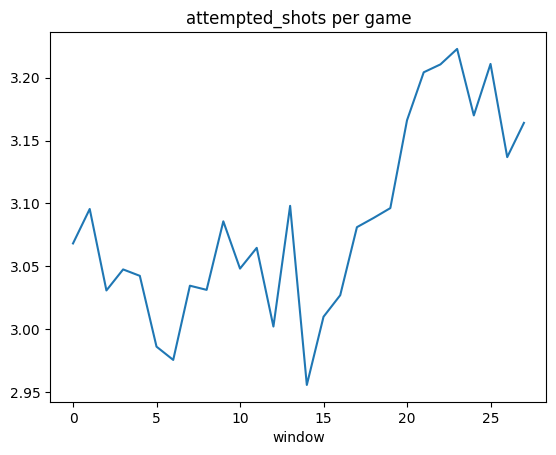

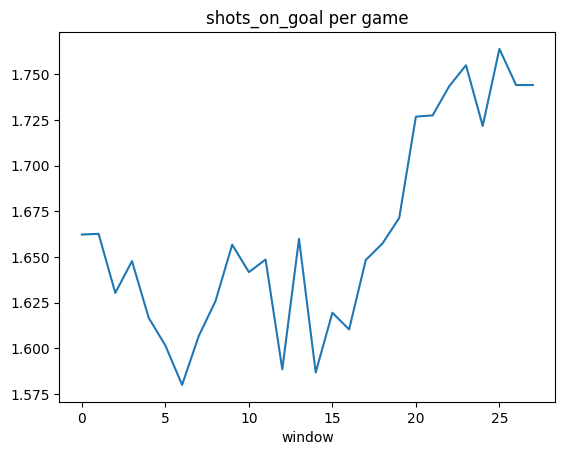

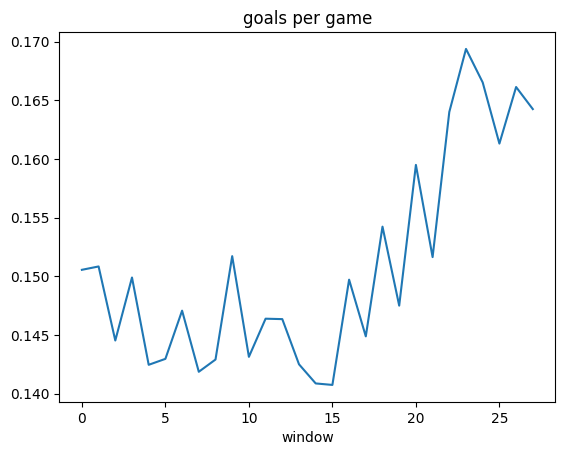

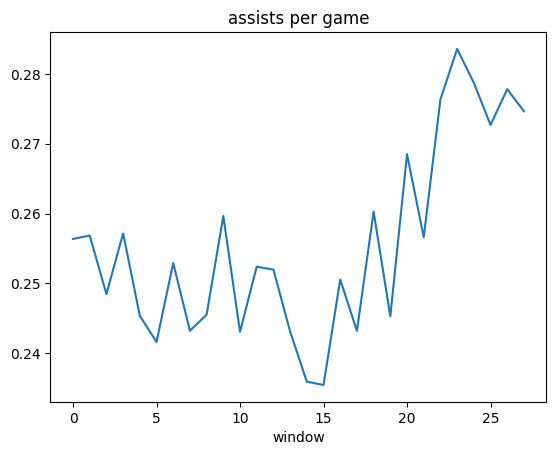

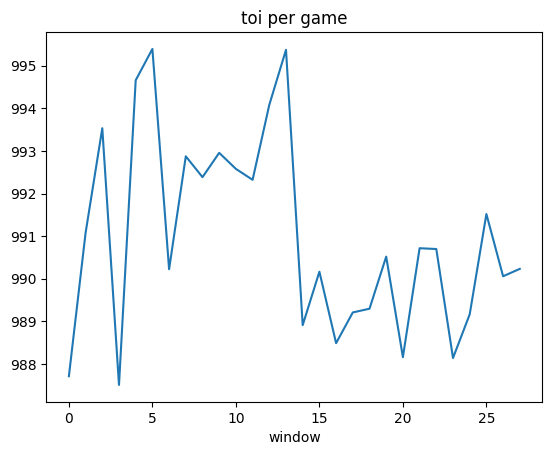

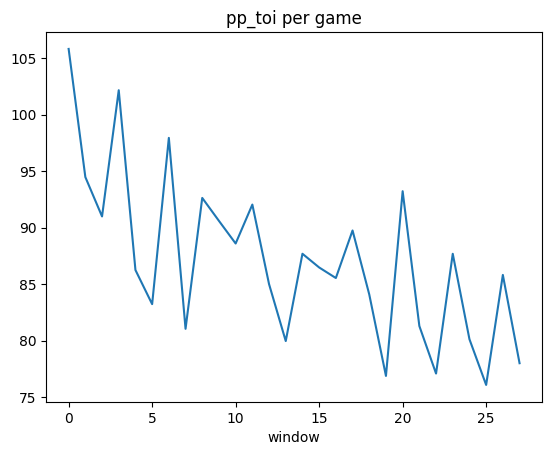

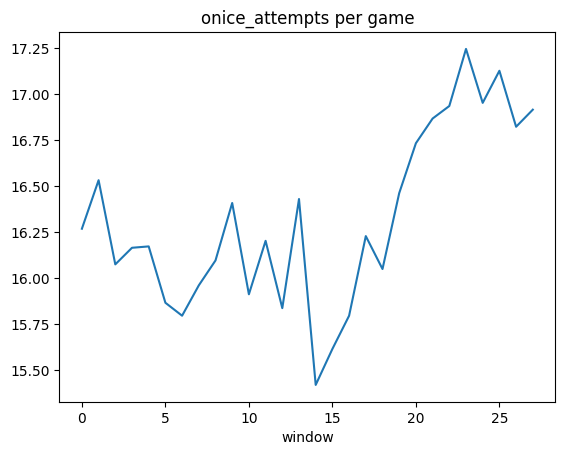

In [43]:
games_sum = player_df.filter(like='games').sum().reset_index(drop=True)

col_names = ['attempted_shots', 'shots_on_goal', 'goals', 'assists', 'toi', 'pp_toi', 'onice_attempts']

for col in col_names:
    col_sum_per_game = (player_df.filter(regex="^" + col).sum().reset_index(drop=True)) / games_sum
    sns.lineplot(col_sum_per_game)
    plt.xlabel('window')
    plt.title(col + ' per game')
    plt.show()

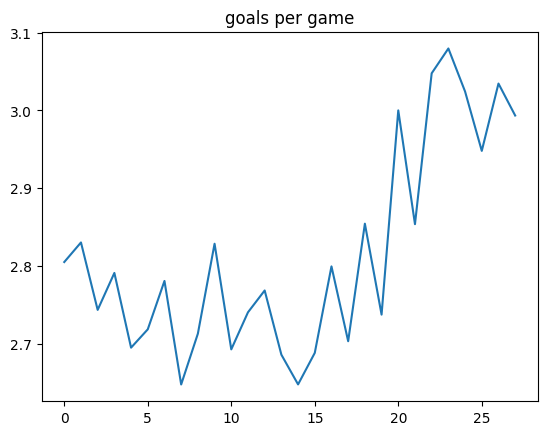

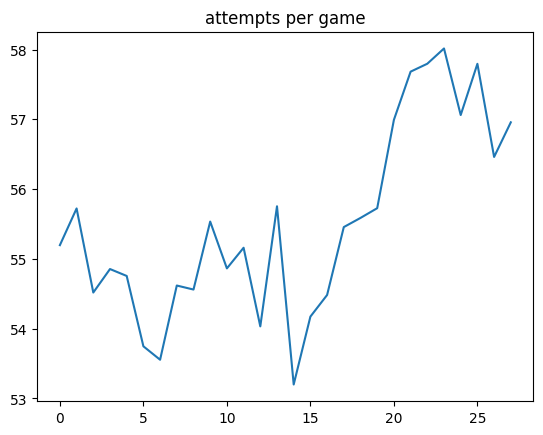

In [44]:
team_games_sum = team_df.filter(like='games').sum().reset_index(drop=True)

col_names = ['goals', 'attempts']

for col in col_names:
    col_sum_per_game = (team_df.filter(regex="^" + col).sum().reset_index(drop=True)) / team_games_sum
    sns.lineplot(col_sum_per_game)
    plt.title(col + ' per game')
    plt.show()

These graphs confirm what we expected: goals, shots-on-goal, and shot attempts all appear to be correlated. Furthermore, we see that offense has increased across the league in the latter third of the decade.

## 9 Saving the data<a id='9_Saving_the_data'></a>

In [45]:
player_df.reset_index(inplace=True)
team_df.reset_index(inplace=True)

In [46]:
datapath = '../data/interim/'

dataframes = [player_df, team_df, my_player_info, df_team_info, windows_df]

names = ['player_data_post_eda', 'team_data_post_eda', 'player_info_post_eda', 'team_info_post_eda', 'windows']

for df, name in zip(dataframes, names):
    save_file(df, name + '.csv', datapath)

Writing file.  "../data/interim/player_data_post_eda.csv"
Writing file.  "../data/interim/team_data_post_eda.csv"
Writing file.  "../data/interim/player_info_post_eda.csv"
Writing file.  "../data/interim/team_info_post_eda.csv"
Writing file.  "../data/interim/windows.csv"


## 10 Summary<a id='10_Summary'></a>

We see that shot attempts are a worthwhile statistic to track, since they are more common than goals or shots-on-goal, but are still correlated with goals.

There is still some work to be done to put our data in a form for training models. The plan is to take goals (or assists, or shots) for each window as our y labels, and creating the corresponding features in X out of the player statistics for recent windows, player info, and recent team statistics.